Latent Dirichlet Allocation (LDA) is a popular form of statistical topic modeling. In LDA, documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. So, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

https://blog.marketmuse.com/glossary/latent-dirichlet-allocation-definition/

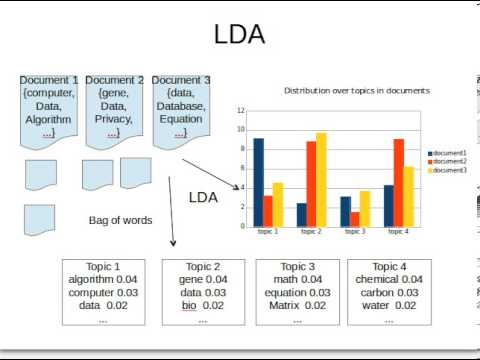

### LDA Intuition

At a high level the LDA model attempts to model two probability distributions given data that is "words present in documents".

1. The probability of a topic over words - $p(word|topic)$ - Each "Topic" is a probability distribution over the words in that topic - for example a topic about sports might have high likelihood words such as "basketball, referree, football".

2. The probability of a document over topics $p(topics|document)$ - Each document can be represented as a probability distribution over "topics" by using the words in the document and the distribution above - for example an article about Davidson beating Duke at basketball might have high likelihood over topics for sports and college.


The approach above makes this model very cool and flexible - providing "soft"/probabalistic membership of documents into many topics - and the choice of the Dirichlet distribution helps to make topics distinct from one another.
Additionally while it is "famous" for working on text - LDA is just an unsupervised learning algorithm that can be used for several downstream algorithms similar to most clustering or matrix factorization algorithms.
If you really want to go deep on the math we've linked the original paper by David Blei and team above.

<img src = "https://www.researchgate.net/publication/346801402/figure/fig1/AS:986776055345152@1612277153515/LDA-underlying-intuition-Generation-of-documents-through-topics-following-the-Dirichlet.png">



### Load dependencies and helper functions

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [133]:
data = pd.read_csv("./data/wp_posts_cleaned.csv")

In [134]:
data.head()

,title,content,link,date,author,type
0,9 eventos de Halloween que no te puedes perder...,Por si andas buscando a qué fiesta llegar ante...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-14T07:05:00,13,post
1,8 terrazas únicas donde puedes tomarte un buen...,En Puerto Rico no faltan los coffee shops. Ya ...,https://www.plateapr.com/terrazas-unicas-donde...,2022-10-13T13:18:57,13,post
2,Todo lo que puedes hacer en Caguas con solo $30,En el amplio valle de Caguas puedes toparte co...,https://www.plateapr.com/que-hacer-en-caguas-p...,2022-10-11T14:20:40,13,post
3,"Jazz, laberintos embrujados y otras 8 activida...","Llegó el mes de las brujas y con él, todas las...",https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-07T02:24:00,13,post
4,3 restaurantes que dan cátedra de recuperación...,A la hora de ser solidarios en la recuperación...,https://www.plateapr.com/restaurantes-recupera...,2022-10-05T17:27:05,34,post


In [135]:
ignore_titles = [
    
                '¿Qué es Platea?',
                 'Terms of Use', 
                 
                 
                 'Gobierno elimina de forma temporera el IVU en los alimentos preparados', 
                 '3 restaurantes que dan cátedra de recuperación tras Fiona',
                 '4 maneras de ayudar a las comunidades de la zona oeste tras el paso del huracán Fiona',
                 'Distrito T-Mobile servirá como centro de acopio para brindar ayuda a los damnificados por el huracán Fiona',
                 'Tu negocio podría recibir ayuda económica ante daños causados por el huracán Fiona',
                 'Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla',
                 'Cancelación de eventos por el paso de la tormenta Fiona',
                ]
ignore_index = []
for index, row in data.iterrows():
    if row['title'] in ignore_titles:
        ignore_index.append(index)
    
    print(index, row['title'])
                            
    

0 9 eventos de Halloween que no te puedes perder esta semana
1 8 terrazas únicas donde puedes tomarte un buen café
2 Todo lo que puedes hacer en Caguas con solo $30
3 Jazz, laberintos embrujados y otras 8 actividades para este fin de semana en octubre
4 3 restaurantes que dan cátedra de recuperación tras Fiona
5 4 maneras de ayudar a las comunidades de la zona oeste tras el paso del huracán Fiona
6 Distrito T-Mobile servirá como centro de acopio para brindar ayuda a los damnificados por el huracán Fiona
7 Tu negocio podría recibir ayuda económica ante daños causados por el huracán Fiona
8 Gobierno elimina de forma temporera el IVU en los alimentos preparados
9 Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla
10 Nueve panaderías artesanales alrededor de la isla para saciar tus antojos
11 Cancelación de eventos por el paso de la tormenta Fiona
12 Volverán a elevar el globo de Jayuya
13 Coffee shops para coffee lovers en San Juan
14 Cinco spots únicos para pa

In [136]:
ignore_index

[4, 5, 6, 7, 8, 9, 11, 81, 114]

In [137]:
data=data.drop(index=ignore_index).reset_index()

In [138]:
data.shape

(175, 7)

In [139]:
texts = data.content

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [165]:
places_tags = ['restaurantes',
 'ocean-park',
 'aire-libre',
 'fine-dining',
 'deportes',
 'hospedajes',
 'boutique-hotels',
 'comida-italiana',
 'cocteles',
 'hiking',
 'cuevas',
 'clases-y-workshops',
 'bakery',
 'wi-fi',
 'aventura',
 'drinks',
 'entretenimiento',
 'panaderias',
 'coffee-shops',
 'bed-amp-breakfast',
 'dinner',
 'tapas',
 'arte-y-cultura',
 'hidden-gem',
 'seafood',
 'comida-del-medio-oriente',
 'ecoturismo',
 'adventure',
 'turismo-interno',
 'mariscos',
 'familiar',
 'comida-internacional',
 'comida-americana',
 'opciones-vegetarianas-y-veganas',
 'airbnb',
 'budget-friendly',
 'food-truck',
 'reposteria',
 'brewery',
 'musica-en-vivo',
 'tours',
 'area-metro',
 'playas',
 'barras',
 'nightlife',
 'eventos',
 'parques-y-reservas',
 'shopping',
 'outdoor-dining',
 'speakeasy',
 'plaza-publica',
 'comida-vegetariana-y-vegana',
 'things-to-do',
 'comida-criolla',
 'juegos-y-diversion',
 'parking',
 'chinchorro',
 'casual-dining',
 'comida-fusion',
 'family-friendly',
 'parques',
 'museos',
 'comida-mexicana',
 'gratis',
 'pizzeria',
 'heladerias',
 'comida-asiatica',
 'mountain-bike',
 'pet-friendly',
 'rooftop',
 'postres',
 'adjuntas',
 'brunch']

places_tags = [s.split('-') for s in places_tags]



tags = []
for t in places_tags:
    if isinstance(t, list):
        tags = tags + t
    else:
        tags.append(t)
        
        
tags = ['parking',]

In [166]:
# Stop Words in spanish from: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# In addition to those we added the stop words for english since we do have some spanglish on the blogs

stop_words = []

with open("./data/stop_words.txt", "r") as file:
    stop_words = file.readlines()
stop_words = [s.strip().lower() for s in stop_words]
stop_words = stop_words + tags
stop_words[len(stop_words)-10: len(stop_words)-1]

['we', 'this', 'on', 'other', 'under', 'use', 'promotions', '', 'parking']

In [167]:
#define our vectorizer class


# We also tried the Tfid vectorizer but the results on the CountVectorizer seemed better.
# tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))


In [168]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [169]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)

Shape = (175, 10000)


In [170]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
andas,1194
buscando,2050
fiesta,4540
llegar,5516
acabe,824
semana,8554
brujas,1989
lista,5472
decidir,3625
favorita,4519


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [171]:
n_components = 5
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [204]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [208]:
tf_feature_names

array(['00', '00 00', '00 10', ..., 'único podrás', 'único restaurante',
       'únicos'], dtype=object)

### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

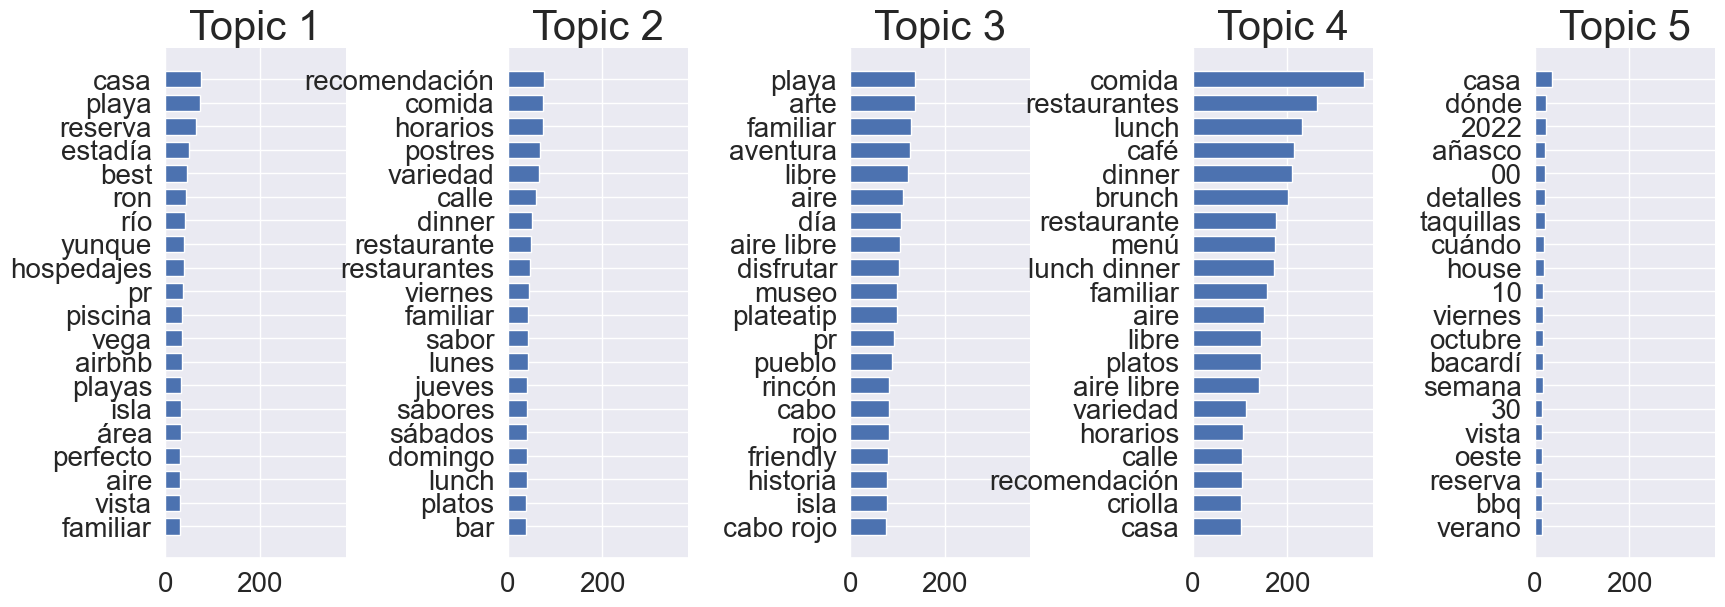

In [212]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "")

In [174]:
len(tf_feature_names)

10000

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [175]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

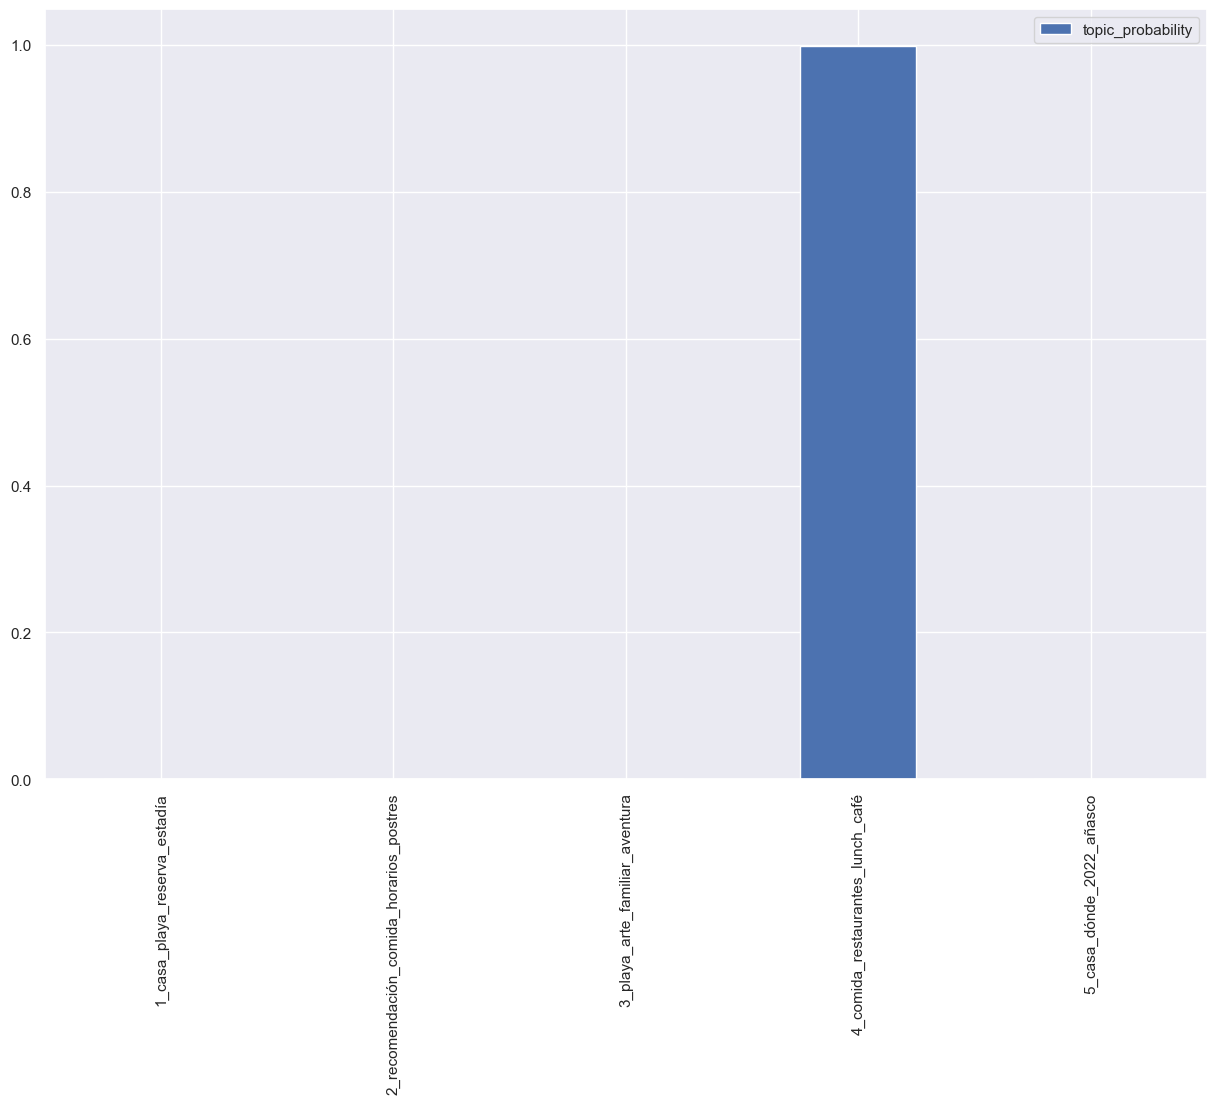

In [178]:
pd.DataFrame(index= topic_names, data= clusters[np.random.choice(len(texts))], columns = ["topic_probability"]).plot.bar(figsize = (15,10), rot=90)
plt.show()

In [179]:
titles = data.title
topics = []
for i in range(len(data)):
    probs = pd.DataFrame(index= topic_names, data= clusters[i], columns = ["topic_probability"])
    # print(titles[i], ": ",probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0])
    topics.append(probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0]) 


In [180]:
data['topic']=topics  
data.head()


,index,title,content,link,date,author,type,topic
0,0,9 eventos de Halloween que no te puedes perder...,Por si andas buscando a qué fiesta llegar ante...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-14T07:05:00,13,post,5_casa_dónde_2022_añasco
1,1,8 terrazas únicas donde puedes tomarte un buen...,En Puerto Rico no faltan los coffee shops. Ya ...,https://www.plateapr.com/terrazas-unicas-donde...,2022-10-13T13:18:57,13,post,4_comida_restaurantes_lunch_café
2,2,Todo lo que puedes hacer en Caguas con solo $30,En el amplio valle de Caguas puedes toparte co...,https://www.plateapr.com/que-hacer-en-caguas-p...,2022-10-11T14:20:40,13,post,3_playa_arte_familiar_aventura
3,3,"Jazz, laberintos embrujados y otras 8 activida...","Llegó el mes de las brujas y con él, todas las...",https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-07T02:24:00,13,post,5_casa_dónde_2022_añasco
4,10,Nueve panaderías artesanales alrededor de la i...,"No hay nada mejor que un pan bien tostado, con...",https://www.plateapr.com/panaderias-artesanales/,2022-09-16T01:20:00,5,post,2_recomendación_comida_horarios_postres


In [181]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})
counts

,topic,count
0,3_playa_arte_familiar_aventura,62
1,4_comida_restaurantes_lunch_café,56
2,2_recomendación_comida_horarios_postres,25
3,1_casa_playa_reserva_estadía,20
4,5_casa_dónde_2022_añasco,12


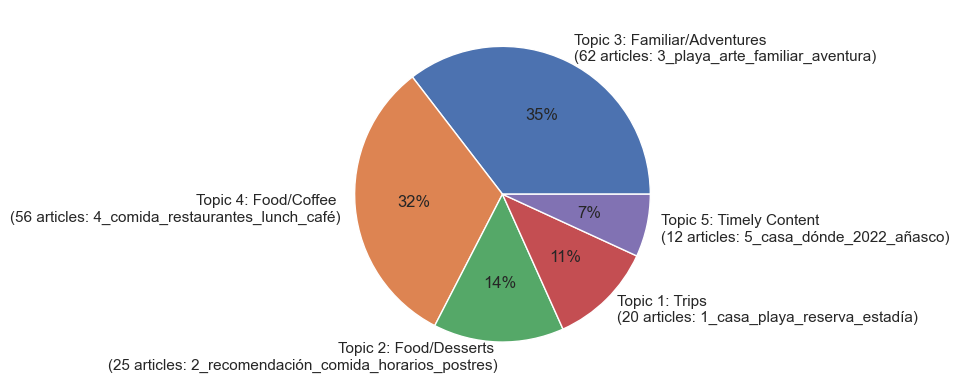

In [198]:

labels = []
broader_names = ['Trips', 'Food/Desserts', 'Familiar/Adventures', 'Food/Coffee', 'Timely Content']


topic_described = {}
for value, topic in zip(counts['count'].values, counts.topic.values):
    index = int(topic[0])
    
    labels.append(f'Topic {index}: {broader_names[index-1]} \n({value} articles: {topic})')
    topic_described[topic] = f'Topic {index}: {broader_names[index-1]} \n({value} articles)'

plt.pie(counts['count'].values, labels = labels, autopct='%.0f%%')
plt.show()

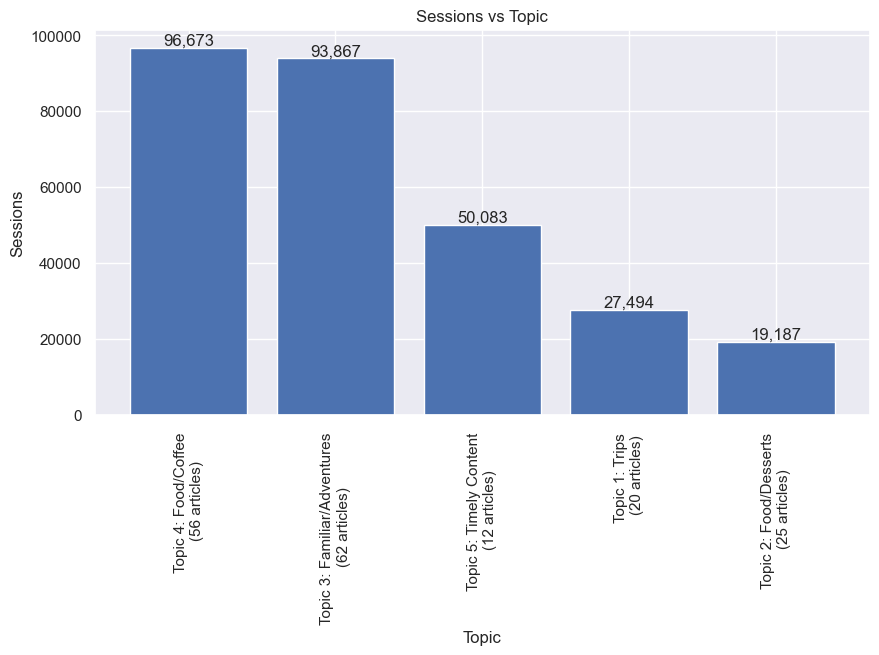

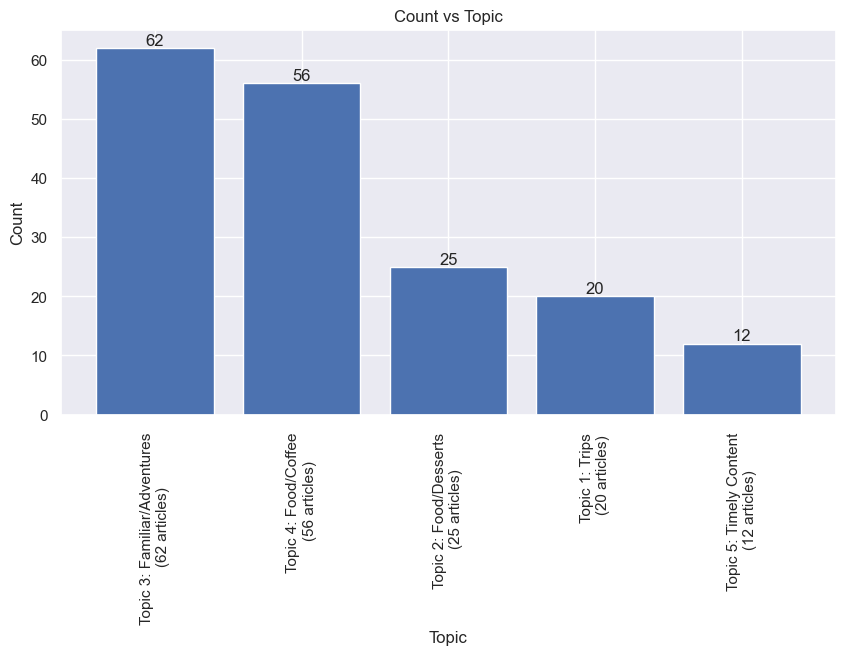

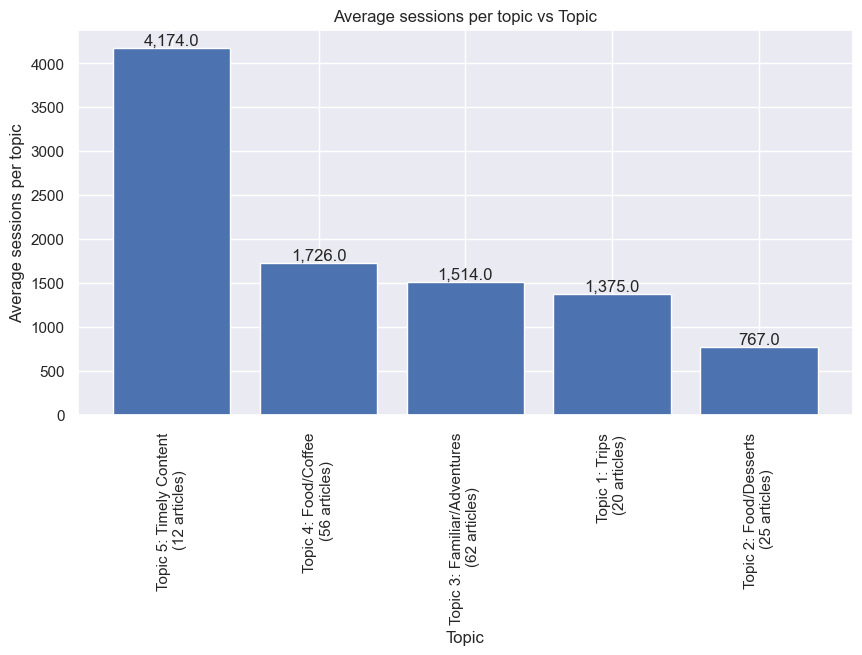

In [199]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})


combined = pd.merge(data,  pd.read_csv("./data/sessions_sum.csv"), how='inner', left_on = 'link', right_on = 'url_clean')
# combined['topic_described'] = [topic_described[topic] for topic in combined['topic']]
by_topic = combined.groupby('topic').agg({'sessions': 'sum'}).reset_index()
by_topic = pd.merge(by_topic, counts, how='inner', left_on = 'topic', right_on = 'topic')

by_topic['Average sessions per topic'] = round(by_topic['sessions']/by_topic['count'],0)

by_topic['topic_described'] = [topic_described[topic] for topic in by_topic['topic']]

y_values = [c for c in by_topic.columns if (c != 'topic' and  c != 'topic_described')]
for c in y_values:
    sorted_df = by_topic.sort_values(by=[c], ascending=False)
    figure = plt.figure('myfigureid', figsize = (10,5))
    axis = figure.add_subplot(1,1,1)
    axis.bar(sorted_df['topic_described'], sorted_df[c])
    
    rects = axis.patches

    # Make some labels.

    for rect, label in zip(rects, sorted_df[c]):
        height = rect.get_height()
        axis.text(
            rect.get_x() + rect.get_width() / 2, height, "{:,}".format(label), ha="center", va="bottom"
        )

    axis.set_ylabel(c.capitalize())
    axis.set_xlabel('topic'.capitalize())
    axis.set_title(f"{c.capitalize()} vs Topic")
    plt.xticks(rotation = 90)
    plt.show()

In [203]:
# See the titles on each topic to get an idea


pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

for topic in counts['topic'].values:
    print(topic_described[topic], topic)
    curr_topic = combined[combined.topic ==topic].sort_values(by=['sessions'], ascending=False)
    print(curr_topic[['title', 'sessions']])
    print('\n')

Topic 3: Familiar/Adventures 
(62 articles) 3_playa_arte_familiar_aventura
                                                                     title  sessions
28   Un Verano Viewing Party: Lo que debes saber antes de llegar            4620    
9    Librerías locales con café para refugiarte durante los días lluviosos  4302    
18   Spots en el oeste para ver la puesta del sol                           4282    
34   17 paradas obligatorias para hacer en Rincón, Puerto Rico              3903    
67   15 lugares que debes visitar en tus vacaciones de Semana Santa         3872    
..                                                              ...          ...    
105  Spotlight: Mercado Agrícola Natural                                    134     
114  Spots para hacer glamping en cinco pueblos de la isla                  90      
120  8 actividades para tu bucket list de vacaciones                        84      
111  Ocho clases que puedes tomar para salir de la rutina                  

/var/folders/zj/qbh81wyd36s5xgr4pxwy71k80000gq/T/ipykernel_9364/1265818788.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [202]:
# See the titles on each topic to get an idea

for topic in counts['topic'].values:
    print(topic)
    for title in combined[combined.topic ==topic]['title'].values:
        print(f'\t\t{title}')
    print('\n')

3_playa_arte_familiar_aventura
		Todo lo que puedes hacer en Caguas con solo $30
		Volverán a elevar el globo de Jayuya
		Cinco spots únicos para paint and wine en el área metro
		¿Hasta cuándo seguirá abierto Las Cascadas Water Park en Aguadilla?
		Librerías locales con café para refugiarte durante los días lluviosos
		Trap Kitty Festival: Young Miko convoca a sus gatitxs a un evento masivo en Mayagüez
		¡Día del Perro en Puerto Rico! Los 6 jangueos para celebrar con tu mascota
		Distrito T-Mobile celebrará su primer aniversario por todo lo alto y esto es lo que debes saber
		Spots en el oeste para ver la puesta del sol
		7 Airbnbs en el Viejo San Juan por menos de $150 la noche
		Los mejores Airbnb&#8217;s en Puerto Rico por menos de $100 la noche
		5 razones para visitar el Taste Food Fest en Plaza Las Américas
		Qué hacer y comer con $30 en la Calle Loíza
		Un Verano Viewing Party: Lo que debes saber antes de llegar
		Ocho actividades gratuitas para cerrar este verano como se debe


In [201]:
combined.groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30].groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30]

,link,sessions,views,return_visitors
20,https://www.plateapr.com/que-hacer-este-fin-de...,35055,87706,10516
21,https://www.plateapr.com/restaurantes-con-vist...,8899,14987,2276
25,https://www.plateapr.com/restaurantes-hidden-g...,6328,16617,1657
29,https://www.plateapr.com/ver-el-live-del-conci...,4620,10279,743
11,https://www.plateapr.com/lugares-para-celebrar...,4619,6847,705
1,https://www.plateapr.com/alquileres-vacacional...,4582,6481,851
8,https://www.plateapr.com/librerias-locales-en-...,4302,7998,948
28,https://www.plateapr.com/spots-para-ver-el-ata...,4282,7055,1348
18,https://www.plateapr.com/playas-escondidas-en-...,4245,10478,1255
23,https://www.plateapr.com/restaurantes-en-caguas/,4186,6389,1237
